# K-Means Clustering Implementation   
## Liam Quinlan
CS 339   
Dr. Kretchmar

### Importing packages

In [165]:
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path
import pandas as pd

datadir = "data"

### K-Means function

In [166]:
def kmeans(data, k):
    # Initialization
    centers = np.zeros((k,data.shape[1]))
    new_centers = np.zeros((k,data.shape[1]))
    distances = np.ones((k,data.shape[0]))

    sample_indices = np.random.choice(data.shape[0], k, replace=False)
    centers = data[sample_indices]
    # print("Centers:\n", centers, "\n")

    # Learning
    for _ in range(20):
        # Compute Distances
        for x in range(k):
            for y in range(0,data.shape[0]):
                distance = np.linalg.norm(centers[x] - data[y])
                distances[x][y] = distance
        # print("Distances:\n", distances)

        # Identify closest clusters
        clusters = np.argmin(distances,axis=0)
        # print("Clusters:\n", clusters)

        # Update centers
        for z in range(k):
            new_centers[z] = np.array(data[clusters == z].mean(axis=0))
        # print("New Centers:\n", new_centers, "\n")

        # Check for repeat centers
        does_array_repeat = centers == new_centers
        if np.all(does_array_repeat) == True:
            break

        centers = new_centers

    return centers, clusters

In [167]:
def normalize(data):
    normalized_columns = []

    for x in range(0,data.shape[1]):
        column = data[:,x]

        min = np.min(column)
        column = column - min

        max = np.max(column)
        column = column / max

        normalized_columns.append(column)

    normalized_data = np.stack(normalized_columns, axis=1)

    return normalized_data

In [168]:
def standardize(data):
    standardized_columns = []

    for x in range(0,data.shape[1]):
        column = data[:,x]

        mean = np.mean(column)
        st_dev = np.std(column)

        column = (column - mean) / st_dev

        standardized_columns.append(column)

    standardized_data = np.stack(standardized_columns, axis=1)

    return standardized_data

In [169]:
# def calculate_mse(data, centers, clusters):
#     average_standard_error_list = []
#     cluster_size_list = []

#     # calculate mse for each cluster
#     for x in range(0,centers.shape[0]):        
#         data_by_cluster = data[clusters == x]
#         cluster_size = data_by_cluster.shape[0]

#         deviations = data_by_cluster - centers[x]
#         variances = np.var(deviations, axis=0)

#         standard_errors = np.sqrt(variances) / np.sqrt(cluster_size)

#         average_standard_error = np.mean(standard_errors)

#         average_standard_error_list.append(average_standard_error)
#         cluster_size_list.append(cluster_size)

#     # calculate weighted average of mses
#     for y in range(len(cluster_size_list)):
#         average_standard_error_list[y] = average_standard_error_list[y] * cluster_size_list[y]

#     std_err_sum = np.sum(average_standard_error_list)
    
#     mean_standard_error = std_err_sum / data.shape[0]
        
#     return mean_standard_error

In [170]:
def calculate_mse(data, centers, clusters):
    average_squared_error_list = []
    cluster_size_list = []

    # calculate mse for each cluster
    for x in range(0,centers.shape[0]):
        data_by_cluster = data[clusters == x]
        cluster_size = data_by_cluster.shape[0]

        errors = data_by_cluster - centers[x]
        squared_errors = errors * errors

        mean_squared_error = np.mean(squared_errors)

        average_squared_error_list.append(mean_squared_error)
        cluster_size_list.append(cluster_size)

    # calculate weighted average of mses
    for y in range(len(cluster_size_list)):
        average_squared_error_list[y] = average_squared_error_list[y] * cluster_size_list[y]

    squared_error_sum = np.sum(average_squared_error_list)

    mse = squared_error_sum / data.shape[0]

    return mse

In [171]:
def kmeans_wrapper(data, k, n):
    mse_list = np.empty(0)
    centers_list = []
    
    for _ in range(n):
        centers, clusters = kmeans(data, k)
        mse = calculate_mse(data, centers, clusters)
        mse_list = np.append(mse_list, mse)
        centers_list.append(centers)
        
        print("MSE: ", mse)
        print("Centers:\n", centers, "\n")

    min_mse_index = np.argmin(mse_list)
    min_mse = np.min(mse_list)
    best_centers = centers_list[min_mse_index]

    return min_mse, best_centers

In [172]:
def elbow_plot(data, n):
    k_vs_mse_list = np.empty((0,2)) 

    for k in range(1, n+1):
        centers, clusters = kmeans(data, k)
        mse = calculate_mse(data, centers, clusters)
        k_vs_mse = np.array([k, mse])
        k_vs_mse_list = np.append(k_vs_mse_list, [k_vs_mse], axis=0)

    print(k_vs_mse_list)

    plt.scatter(k_vs_mse_list[:,0], k_vs_mse_list[:,1])
    plt.show()

    return

### Testing K-Means on a small dataset

In [173]:
# initialize data
data1 = np.array([[1,2],[1,3],[1,5],[2,3],[2,1],[6,7],[5,6],[5,9],[7,6],[8,6]])
print(data1)

[[1 2]
 [1 3]
 [1 5]
 [2 3]
 [2 1]
 [6 7]
 [5 6]
 [5 9]
 [7 6]
 [8 6]]


In [174]:
centers, clusters = kmeans(data1, 2)

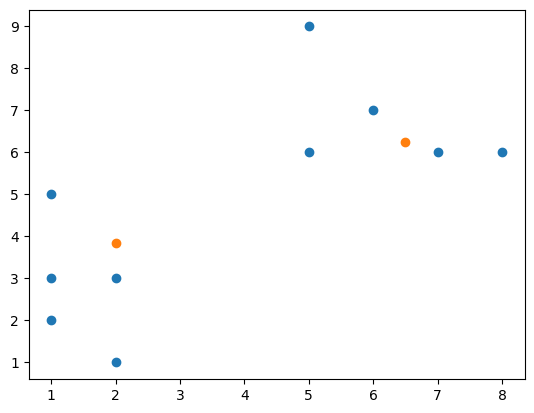

In [175]:
plt.scatter(data1[:, 0], data1[:, 1])
plt.scatter(centers[:, 0], centers[:, 1])

plt.show()

### Performing Cluster Analysis on S&P500 market data to encourage portfolio diversification

In [176]:
def readData(filepath):
    file = open(filepath, 'r')

    LoL = []

    for line in file:
        vals = line.strip().split(',')
        temp_list = []
        for val in vals:
            temp_list.append(val)
        LoL.append(temp_list)

    file.close()

    return LoL

In [177]:
listOfLists = readData(os.path.join(datadir, "financials.csv"))

financialsDF = pd.DataFrame(listOfLists[1:], columns=listOfLists[0])

financialsDF

,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings
0,MMM,3M Company,Industrials,222.89,24.31,2.3328617,7.92,259.77,175.49,138721055226,9048000000,4.3902707,11.34,http://www.sec.gov/cgi-bin/browse-edgar?action...
1,AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.1479592,1.7,68.39,48.925,10783419933,601000000,3.5754826,6.35,http://www.sec.gov/cgi-bin/browse-edgar?action...
2,ABT,Abbott Laboratories,Health Care,56.27,22.51,1.9089824,0.26,64.6,42.28,102121042306,5744000000,3.7404804,3.19,http://www.sec.gov/cgi-bin/browse-edgar?action...
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.4995599,3.29,125.86,60.05,181386347059,10310000000,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...
4,ACN,Accenture plc,Information Technology,150.51,25.47,1.7144699,5.44,162.6,114.82,98765855553,5643228000,2.604117,10.62,http://www.sec.gov/cgi-bin/browse-edgar?action...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,XYL,Xylem Inc.,Industrials,70.24,30.94,1.1700794,1.83,76.81,46.86,12915021000,722000000,2.7262094,5.31,http://www.sec.gov/cgi-bin/browse-edgar?action...
501,YUM,Yum! Brands Inc,Consumer Discretionary,76.3,27.25,1.7970798,4.07,86.93,62.85,27003303098,2289000000,6.3136363,212.08,http://www.sec.gov/cgi-bin/browse-edgar?action...
502,ZBH,Zimmer Biomet Holdings,Health Care,115.53,14.32,0.7948336,9.01,133.49,108.17,24454698119,2007400000,3.1648953,2.39,http://www.sec.gov/cgi-bin/browse-edgar?action...
503,ZION,Zions Bancorp,Financials,50.71,17.73,1.480933,2.6,55.61,38.43,10670678640,0,3.7945793,1.42,http://www.sec.gov/cgi-bin/browse-edgar?action...


In [178]:
financialsDFClean = financialsDF.copy()

columns_to_drop = ["Symbol","Name","Sector","Price","Price/Earnings","Earnings/Share","52 Week Low","52 Week High","EBITDA","Price/Sales","Price/Book","SEC Filings"]
financialsDFClean.drop(columns_to_drop, axis=1, inplace=True)

lf = lambda string_to_float: float(string_to_float)
financialsDFClean["Dividend Yield"] = financialsDFClean["Dividend Yield"].apply(lf)
financialsDFClean["Market Cap"] = financialsDFClean["Market Cap"].apply(lf)

financialsDFClean

,Dividend Yield,Market Cap
0,2.332862,1.387211e+11
1,1.147959,1.078342e+10
2,1.908982,1.021210e+11
3,2.499560,1.813863e+11
4,1.714470,9.876586e+10
...,...,...
500,1.170079,1.291502e+10
501,1.797080,2.700330e+10
502,0.794834,2.445470e+10
503,1.480933,1.067068e+10


In [179]:
financials_array = financialsDFClean.to_numpy()
financials_array = normalize(financials_array)

print(financials_array)

[[0.18425287 0.16866774]
 [0.09066752 0.01010968]
 [0.15077426 0.12330793]
 ...
 [0.06277713 0.02705302]
 [0.11696628 0.00996995]
 [0.05389475 0.04135055]]


[[1.00000000e+00 1.35710219e-02]
 [2.00000000e+00 9.14474669e-03]
 [3.00000000e+00 6.28222341e-03]
 [4.00000000e+00 7.55520336e-03]
 [5.00000000e+00 5.96467573e-03]
 [6.00000000e+00 3.66140594e-03]
 [7.00000000e+00 4.13440860e-03]
 [8.00000000e+00 2.73734567e-03]
 [9.00000000e+00 1.84122613e-03]
 [1.00000000e+01 2.83765970e-03]
 [1.10000000e+01 3.40388969e-03]
 [1.20000000e+01 3.04904083e-03]
 [1.30000000e+01 3.18327037e-03]
 [1.40000000e+01 3.11208630e-03]
 [1.50000000e+01 3.27215779e-03]
 [1.60000000e+01 2.45399701e-03]
 [1.70000000e+01 1.21669799e-03]
 [1.80000000e+01 3.14175488e-03]
 [1.90000000e+01 2.48742425e-03]
 [2.00000000e+01 1.84622130e-03]
 [2.10000000e+01 2.06873107e-03]
 [2.20000000e+01 8.15369645e-04]
 [2.30000000e+01 2.26790961e-03]
 [2.40000000e+01 1.63764768e-03]
 [2.50000000e+01 1.09003030e-03]
 [2.60000000e+01 2.61333606e-03]
 [2.70000000e+01 4.52850669e-04]
 [2.80000000e+01 9.70233896e-04]
 [2.90000000e+01 1.31283177e-03]
 [3.00000000e+01 1.48664887e-03]]


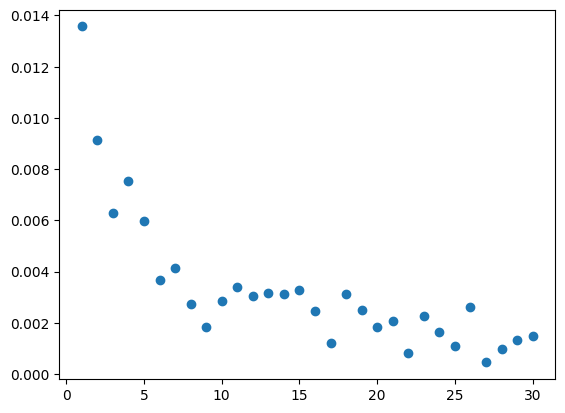

In [180]:
elbow_plot(financials_array, 30)

In [181]:
centers, clusters = kmeans(financials_array, 10)

print(centers)

[[0.01580608 0.12252951]
 [0.08467026 0.06027845]
 [0.08296248 0.01607108]
 [0.35056322 0.0242543 ]
 [0.20912984 0.0899117 ]
 [0.00195035 0.03603595]
 [0.04547138 0.85832173]
 [0.00345002 0.01185578]
 [0.19995122 0.28233007]
 [0.17225632 0.02290767]]


In [182]:
best_mse, best_centers = kmeans_wrapper(financials_array, 10, 10)

MSE:  0.003366493153263738
Centers:
 [[0.12121134 0.01626986]
 [0.34867152 0.03460107]
 [0.08795383 0.01649106]
 [0.00416401 0.012901  ]
 [0.22200675 0.05913898]
 [0.00231664 0.06697   ]
 [0.06643642 0.04948733]
 [0.14487347 0.44929182]
 [0.16533386 0.01815267]
 [0.14050491 0.08657771]] 

MSE:  0.003260077277109861
Centers:
 [[1.34063345e-01 1.87276363e-02]
 [2.76702594e-01 1.99179558e-02]
 [2.59352252e-04 1.12213794e-02]
 [5.68168978e-02 1.75382339e-02]
 [4.27086228e-01 6.56397075e-02]
 [2.04977450e-01 6.41952930e-02]
 [1.27647406e-01 4.10719538e-01]
 [1.66271321e-02 1.67275253e-02]
 [1.66501878e-03 5.18121849e-02]
 [1.02299553e-01 6.41545724e-02]] 

MSE:  0.002880973895224551
Centers:
 [[0.00302563 0.02647112]
 [0.06545762 0.03766559]
 [0.29925042 0.03409898]
 [0.48207311 0.02065839]
 [0.08843733 0.01404898]
 [0.16397867 0.13301948]
 [0.17018677 0.42716197]
 [0.21960759 0.02540758]
 [0.11142373 0.02042975]
 [0.14953262 0.03038762]] 

MSE:  0.002137357895389847
Centers:
 [[2.15882421e

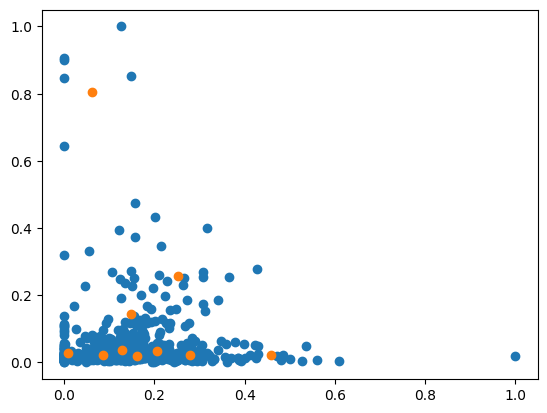

In [183]:
plt.scatter(financials_array[:, 0], financials_array[:, 1])
plt.scatter(best_centers[:,0], best_centers[:,1])

plt.show()